# Transformer for Language Translation implementation in PyTorch

In this notebook I will go trough an PyTorch implementation of transformer based on [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf) paper.

In [another notebook](https://github.com/mf1024/transformers) I implemented Transforer Encoder model and trained it for Language Modeling task. 

In this notebook I will continue and add the Decoder component to the implementation and train the whole on Language Translation task.

Troughout this notebook as well I **use some of the illustrations from the incredible [Illustrated transformer](https://jalammar.github.io/illustrated-transformer) blog post by *Jay Alammar***. I highly recommend you to take a look at it. 


## Dataset

For the translation task I will use a small english-french [dataset](https://raw.githubusercontent.com/mf1024/transformers/master/fra-eng/fra.txt). The dataset consists of just 170k sentences but that is enough to train and demonstrate the Transformer.

I will use the same PyTorch [Dataset](https://github.com/mf1024/transformers/blob/master/fra_eng_dataset.py) implementation to process the sentences and prepare the batches.


## Transformer architecture:

<img src="imgs/transformer.png">

The key idea of Transformer is to avoid using [reccurence](https://arxiv.org/abs/1409.3215) at all for encoding and decoding variable-length sequences. That solves issues with long-range dependencies and the amount of computation that can be parallelized.

The transformer consists of two parts - the Encoder and the Decoder. They are both very similar in their structure but different in a few aspects. 

## The Encoder and Decoder

<img src="imgs/encoder-decoder.png">

In the full Transformer implementation, first, the sentence in the source language is encoded. One the encoding is done, the output of the last encoder layer is used in every layer of decoder, where the last layer generates the sentence in target language. 


<img src="imgs/transformer_decoding.gif">

The Decoder layer consists of same sublayers as Encoder(Self Attention and Feed Forward) with one additional sublayer - Memory Attention. The Memory Attention sublayer is similar to Self Attention except it uses **Key** and **Value** matrices from the Encoder.

The Decoder will use these **Key** and **Value** matrices but will learn to calculate it's own **Query** to gather the information from the encoded sentences.

When decoding the sentence, each word is prediced one at a time, meaning that for Decoder to predict the word x(i) the input of the Decoder should be all the words in target langugae from 1 to i-1 . During the traing the decoding can be paralelized using masking, but during translation it is going to take as many Decoder runs as there are words in the target sentence as shown in the GIF. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch
from torch import nn
import torch.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os

from torch.utils.data import Dataset, DataLoader
from fra_eng_dataset import FraEngDataset, fra_eng_dataset_collate
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

## Attention Layers

In [2]:
class SelfAttentionHead(nn.Module):
    def __init__(self, d_model):
        super().__init__()

        self.d_model = d_model
        self.K = nn.Linear(d_model, d_model)
        self.V = nn.Linear(d_model, d_model)
        self.Q = nn.Linear(d_model, d_model)

    def forward(self, x, padding_mask = None, subsq_mask = None):
        # x shape: [N, SEQ, D_MODEL]

        keys = self.K.forward(x)
        values = self.V.forward(x)
        queries = self.Q.forward(x)

        sqrt_d = self.d_model ** 0.5

        att = torch.matmul(queries, keys.transpose(1,2)) / sqrt_d
        # att shape: [N, SEQ, SEQ]
        # Broadcast padding mask to word attentions so that word attention does not attend to positions outside the sentence
        if padding_mask is not None:
            att = att + padding_mask.transpose(1,2)
        # Add subsequent mask so that each position can attend only itself and the previous elements
        if subsq_mask is not None:
            att = att + subsq_mask.unsqueeze(0)

        att_softmax = torch.softmax(att, dim=2)
        # shape: [N, SEQ, SEQ]
        att_out = torch.matmul(att_softmax, values)
        # shape: [N, SEQ, D_MODEL]

        return att_out, keys, values

### Memory Attention
Implementation is the same as Self Attention only the keys and values matrices are not calculated from weights and input but are passed to the forward function.

In [3]:
class MemAttentionHead(nn.Module):
    def __init__(self, d_model):
        super().__init__()

        self.d_model = d_model
        self.Q = nn.Linear(d_model, d_model)

    def forward(self, x, mem_padding_mask, keys = None, values = None):

        # X shape: [N, SEQ, D_MODEL]
        queries = self.Q.forward(x)
        sqrt_d = self.d_model ** 0.5

        att = torch.matmul(queries, keys.transpose(1,2)) / sqrt_d
        # att shape: [N, SEQ_TGT, SEQ_SRC]

        # Broadcast padding mask to word attentions so that word attention does not attend to positions outside the source sentence
        if mem_padding_mask is not None:
            att = att + mem_padding_mask.transpose(1,2)

        att_softmax = torch.softmax(att, dim=2)
        # shape: [N, SEQ_TGT, SEQ_SRC]
        att_out = torch.matmul(att_softmax, values)
        # shape: [N, SEQ_TGT, D_MODEL]

        return att_out

### Multi-head attentions for Self Attention and Memory Attention

In [4]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()

        self.num_heads = num_heads
        self.heads = nn.ModuleList([SelfAttentionHead(d_model) for i in range(num_heads)])
        self.linear = nn.Linear(num_heads * d_model, d_model)

    def forward(self, src, src_padding_mask, src_subsq_mask):

        out_cat = None
        keys = None
        values = None

        for i in range(self.num_heads):
            head_outp, keys, values = self.heads[i].forward(src, src_padding_mask, src_subsq_mask)

            if i == 0:
                out_cat = head_outp
            else:
                out_cat = torch.cat([out_cat, head_outp], dim=2)

        ret = self.linear.forward(out_cat)

        return ret, keys, values

In [5]:
class MultiHeadMemAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()

        self.num_heads = num_heads
        self.heads = nn.ModuleList([MemAttentionHead(d_model) for i in range(num_heads)])
        self.linear = nn.Linear(num_heads * d_model, d_model)

    def forward(self, src, src_padding_mask, keys, values):

        out_cat = None
        for i in range(self.num_heads):
            head_outp = self.heads[i].forward(src, src_padding_mask, keys = keys, values = values)

            if i == 0:
                out_cat = head_outp
            else:
                out_cat = torch.cat([out_cat, head_outp], dim=2)

        ret = self.linear.forward(out_cat)

        return ret

### Encoder layer

In [6]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_att_heads, ff_dim = 2048, dropout = 0.1):
        super().__init__()

        self.multihead_attention = MultiHeadSelfAttention(d_model, num_att_heads)
        self.dropout1 = nn.Dropout(dropout)
        self.att_sublayer_norm = torch.nn.LayerNorm(d_model)

        self.linear1 = nn.Linear(d_model, ff_dim)
        self.relu = nn.ReLU()
        self.dropout_lin = nn.Dropout(dropout)
        self.linear2 = nn.Linear(ff_dim, d_model)

        self.dropout2 = nn.Dropout(dropout)
        self.lin_sublayer_norm = torch.nn.LayerNorm(d_model)

    def forward(self, src, src_padding_mask, src_subsq_mask):

        residual_1 = src
        x, keys, values = self.multihead_attention.forward(src, src_padding_mask, src_subsq_mask)
        x = self.att_sublayer_norm.forward(residual_1 + self.dropout1(x))

        residual_2 = x
        x = self.linear2(self.dropout_lin(self.relu(self.linear1.forward(x))))
        x = self.lin_sublayer_norm(residual_2 + self.dropout2(x))

        return x, keys, values

### Decoder layer

The only difference between Encoder and Decoder layer is the additional MultiHeadMemAttention() sublayer in the decoder layer.

In [7]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_att_heads, ff_dim = 2048, dropout = 0.1):
        super().__init__()

        self.multihead_self_attention = MultiHeadSelfAttention(d_model, num_att_heads)
        self.self_att_sublayer_norm = torch.nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)

        self.multihead_mem_attention = MultiHeadMemAttention(d_model, num_att_heads)
        self.mem_att_sublayer_norm = torch.nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)

        self.linear1 = nn.Linear(d_model, ff_dim)
        self.dropout_lin = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(ff_dim, d_model)
        self.lin_sublayer_norm = torch.nn.LayerNorm(d_model)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, src_padding_mask, tgt_padding_mask, tgt_subsq_mask, mem_keys, mem_values):

        residual_1 = x
        x, keys, values = self.multihead_self_attention.forward(x, tgt_padding_mask, tgt_subsq_mask)
        x = self.self_att_sublayer_norm.forward(residual_1 + self.dropout1(x))

        residual_2 = x
        x = self.multihead_mem_attention.forward(x, src_padding_mask, keys = mem_keys, values = mem_values)
        x = self.mem_att_sublayer_norm.forward(residual_2 + self.dropout2(x))

        residual_3 = x
        x = self.linear2(self.dropout_lin(self.relu(self.linear1.forward(x))))
        x = self.lin_sublayer_norm(residual_3 + self.dropout3(x))

        return x

### Encoder 

In [8]:
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, num_att_heads):
        super().__init__()
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_att_heads) for i in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)

    def forward(self,src, src_padding_mask, src_subsq_mask):
        x = src

        keys = None
        values = None
        for layer in self.layers:
            x, keys, values = layer.forward(x, src_padding_mask, src_subsq_mask)

        x = self.norm.forward(x)

        return keys, values

### Decoder

In [9]:
class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, num_att_heads):
        super().__init__()
        self.layers = nn.ModuleList([DecoderLayer(d_model, num_att_heads) for i in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, tgt, src_padding_mask, tgt_padding_mask, tgt_subsq_mask, mem_keys, mem_values):
        x = tgt
        for layer in self.layers:
            x = layer.forward(x, src_padding_mask, tgt_padding_mask, tgt_subsq_mask, mem_keys, mem_values)

        x = self.norm.forward(x)

        return x

## Positional Encoding

The attention module itself have no information about the position of other word embeddings in the sentence. In NLP and other sequential data tasks the order of the sequence is critical. To solve this issue the authors of the paper introduce the Positional Encoding method. First they generate a vector containing information about the position in the same size as the embedding and then simply add this vector to the word embedding and hope that the model will learn to recognize it.

They use the following function to generate the positional information: 
<img src="imgs/pos_enc.png">


In [10]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model

        self.sin_args = torch.zeros(1, self.d_model).to(device)
        self.cos_args = torch.zeros(1, self.d_model).to(device)
        for i in range(self.d_model//2):
            self.sin_args[0,i * 2] = 10000**(2.*i/self.d_model)
            self.cos_args[0,i * 2 + 1] = 10000**(2.*i/self.d_model)

        self.sin_args_mask = (self.sin_args > 1e-10).float()
        self.sin_args = self.sin_args + (self.sin_args < 1e-10).float()

        self.cos_args_mask = (self.cos_args > 1e-10).float()
        self.cos_args = self.cos_args + (self.cos_args < 1e-10).float()

    def forward(self, x):
        for pos in range(x.size()[-2]):
            x[:,pos,:] = x[:,pos,:] + \
                         torch.sin(pos / self.sin_args) * self.sin_args_mask + \
                         torch.cos(pos / self.cos_args) * self.cos_args_mask

        return x


Here is a vizualization of the positional encoding vectors. Each row is an encoding for a word. 

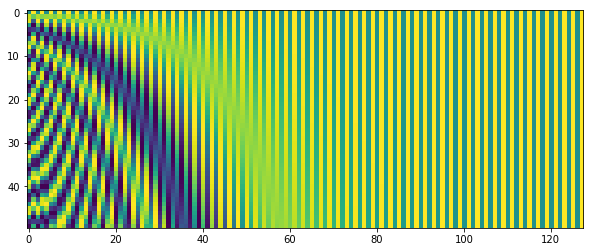

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

positional_enc = PositionalEncoding(128).to(device)
data = torch.zeros(1, 50, 128).to(device)
data_pos_enc = positional_enc.forward(data)

enc_np = data_pos_enc.squeeze(dim=0).to('cpu').numpy()
fig, ax = plt.subplots(figsize=(12, 4))
ax.imshow(enc_np)
plt.show()

## The Transformer model

The biggest addition to the Transformer module is the translate() function. The translate function reads the source sentence, encodes it with one encoder forward run and then using the **Value** and **Key** matrices from encoder it runs the decoder as many times as needed, generating one additional word per run, until the < end-of-sentence > token is generated or max sentence length is reached.

In [12]:

class Transformer(nn.Module):
    def __init__(self, num_layers, d_model, num_att_heads, input_dict_size, output_dict_size):
        super().__init__()

        self.max_sent_len = 50

        self.input_emb = nn.Embedding(input_dict_size, d_model)
        self.outp_emb = nn.Embedding(output_dict_size, d_model)

        self.positional_encoder = PositionalEncoding(d_model)
        self.encoder = Encoder(num_layers, d_model, num_att_heads)
        self.decoder = Decoder(num_layers, d_model, num_att_heads)

        self.outp_logits = nn.Linear(d_model, output_dict_size)
        self.softmax = nn.Softmax(dim=2)

    def translate(self, src, tgt_start_code, tgt_eos_code, src_padding_mask, src_subsq_mask):

        # TODO: Beam search

        enc_x = self.input_emb.forward(src.squeeze(dim=2))
        enc_x = self.positional_encoder.forward(enc_x)
        enc_keys, enc_values = self.encoder.forward(enc_x, src_padding_mask, src_subsq_mask)

        snt = torch.ones((1,1,1)) * tgt_start_code
        snt = snt.long()
        snt = snt.to(device)

        translation_idxes = []

        for idx in range(self.max_sent_len):

            dec_x = self.outp_emb.forward(snt.squeeze(dim=2))
            dec_x = self.positional_encoder.forward(dec_x)
            dec_x = self.decoder.forward(
                dec_x,
                src_padding_mask = src_padding_mask,
                tgt_padding_mask = torch.zeros_like(snt).float().to(device),
                tgt_subsq_mask = get_square_subsequent_mask(snt.size()[1]),
                mem_keys = enc_keys,
                mem_values = enc_values
            )
            dec_x = self.outp_logits.forward(dec_x)
            dec_x = self.softmax(dec_x)
            next_word_softmax = dec_x[0,idx,:].to('cpu').detach()
            next_word_idx = torch.argmax(next_word_softmax)
            snt = torch.cat([snt, torch.ones((1,1,1)).long().to(device) * next_word_idx], dim=1)

            translation_idxes.append(next_word_idx)

            if next_word_idx == tgt_eos_code:
                break

        return translation_idxes


    def forward(self, src, tgt, src_padding_mask, src_subsq_mask, tgt_padding_mask, tgt_subsq_mask):

        enc_x = self.input_emb.forward(src.squeeze(dim=2))
        enc_x = self.positional_encoder.forward(enc_x)
        enc_keys, enc_values = self.encoder.forward(enc_x, src_padding_mask, src_subsq_mask)

        dec_x = self.outp_emb.forward(tgt.squeeze(dim=2))
        dec_x = self.positional_encoder.forward(dec_x)
        dec_x = self.decoder.forward(dec_x, src_padding_mask, tgt_padding_mask, tgt_subsq_mask, enc_keys, enc_values)
        dec_x = self.outp_logits.forward(dec_x)
        dec_x = self.softmax(dec_x)

        return dec_x

### Some helper functions

In [13]:
def get_square_subsequent_mask(seq_len):
    mask = (torch.triu(torch.ones(seq_len, seq_len).to(device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def get_padding_mask(input, val1 = float('-inf'), val2 = float(0.0)):
    mask = torch.ones(input.size()).to(device)
    mask = mask.float().masked_fill(input == 0, val1).masked_fill(input > 0, val2)
    return mask


def get_one_hot(x, out_dim, mask):

    tens = x.view(-1)
    tens_one_hot = torch.zeros(list(tens.size()) + [out_dim]).to(device)
    for i in range(len(tens)):
        tens_one_hot[i,tens[i]] = 1

    tens_one_hot = tens_one_hot.view(list(x.size()) + [out_dim])
    tens_one_hot = tens_one_hot * mask
    return tens_one_hot.to(device)

In [14]:
#Prepare the sentence for model translate function
def translate_sentences(src_sentences, tgt_sentences, max_sent_num = 15):

    transformer_model.eval()

    with torch.no_grad():

        for snt_idx in range(len(src_sentences)):

            if snt_idx > max_sent_num:
                break

            src = src_sentences[snt_idx:snt_idx+1]

            padded_src = pad_sequence(src, padding_value=0, batch_first=True).to(device)
            src_padding_mask = get_padding_mask(padded_src)
            src_subsq_mask = get_square_subsequent_mask(padded_src.size()[1])

            snt_translation = transformer_model.translate(
                src = padded_src,
                tgt_start_code = dataset.get_eng_start_code(),
                tgt_eos_code = dataset.get_eng_eos_code(),
                src_padding_mask = src_padding_mask,
                src_subsq_mask = src_subsq_mask
            )

            src_sent = ''
            for word_idx in src_sentences[snt_idx]:
                src_sent = f"{src_sent} {dataset.fra_token_to_text[word_idx]}"

            tgt_sent = ''
            for word_idx in tgt_sentences[snt_idx]:
                tgt_sent = f"{tgt_sent} {dataset.eng_token_to_text[word_idx]}"

            translated_sent = ''
            for word_idx in snt_translation:
                translated_sent = f"{translated_sent} {dataset.eng_token_to_text[word_idx]}"

            print(f"Source sentence is: {src_sent}")
            print(f"Target sentence is: {tgt_sent}")
            print(f"Model translation is: {translated_sent}")

    transformer_model.train()

### Hyperparams, model definition and dataset

In [15]:
BATCH_SIZE = 64
LEARNING_RATE = 1e-4
EPOCHS = 20
STORE_MODELS = True
models_path = 'models'

if not os.path.exists(models_path):
    os.mkdir(models_path)

dataset = FraEngDataset()
sentences_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, collate_fn=fra_eng_dataset_collate)

in_dict_size = dataset.get_fra_dict_size()
out_dict_size = dataset.get_eng_dict_size()

transformer_model = Transformer(
    num_layers=6,
    d_model=512,
    num_att_heads=8,
    input_dict_size=in_dict_size,
    output_dict_size=out_dict_size
).to(device)

optimizer = torch.optim.Adam(transformer_model.parameters(), lr = 1e-4)


170190


# Training and sentence translation
To follow the porgress of the model closer I will run translation of few sentences after every 500 processed batches. 

In [16]:
batch_count = 0

for epoch in range(EPOCHS):

    train_loss_sum = 0.0
    total_word_count = 0.0

    for sentences in sentences_loader:

        src_sentences = sentences['fra_sentences']
        tgt_sentences = sentences['eng_sentences']

        batch_count+=1
        if batch_count % 500 == 0:
            print("#" * 10 + f"  Few translations after {batch_count} batches  " + "#" * 60)
            translate_sentences(src_sentences,tgt_sentences)
            continue

        tgt_sentences_out = []

        for idx in range(len(tgt_sentences)):
            tgt_sentences_out.append(tgt_sentences[idx][1:])
            tgt_sentences[idx] = tgt_sentences[idx][:-1]

        # Create tensors from token lists
        padded_src = pad_sequence(src_sentences, padding_value=0, batch_first=True).to(device)
        padded_tgt = pad_sequence(tgt_sentences, padding_value=0, batch_first=True).to(device)
        padded_tgt_out = pad_sequence(tgt_sentences_out, padding_value=0, batch_first=True).to(device)

        src_padding_mask = get_padding_mask(padded_src)
        src_subsq_mask = get_square_subsequent_mask(padded_src.size()[1])

        tgt_padding_mask = get_padding_mask(padded_tgt)
        tgt_subsq_mask = get_square_subsequent_mask(padded_tgt.size()[1])


        pred = transformer_model.forward(
            src=padded_src,
            tgt=padded_tgt,
            src_padding_mask=src_padding_mask,
            src_subsq_mask=src_subsq_mask,
            tgt_padding_mask=tgt_padding_mask,
            tgt_subsq_mask=tgt_subsq_mask
        )

        # Mask to zero one hot vectors corresponding to padded elements
        one_hot_mask = get_padding_mask(padded_tgt_out, val1=float(0.0), val2=float(1.0))
        y_one_hot = get_one_hot(padded_tgt_out.squeeze(dim=2), out_dict_size, mask=one_hot_mask)

        loss = - torch.sum(torch.log(pred) * y_one_hot)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss_sum += loss.detach().to('cpu').data
        total_word_count += torch.sum(y_one_hot).to('cpu').data

    print(f"Epoch {epoch} " + '=' * 60)
    print(f"Total loss per word: {train_loss_sum / total_word_count}")
    print(f"Some translated sentences:")
    

    if STORE_MODELS == True:
        model_path = os.path.join(models_path, f'Epoch_{epoch}_model.pt')
        torch.save(transformer_model, model_path)

print("Traing done! Generating some more sentences.")


##########  Few translations after 500 batches  ############################################################
Source sentence is:  Êtes-vous sûr de ne pas vouloir attendre jusqu ' à demain ? <EOS>
Target sentence is:  <START> Are you sure you do n't want to wait till tomorrow ? <EOS>
Model translation is:  Are you sure you do n't want to be here ? <EOS>
Source sentence is:  Je ne sais pas en ce qui te concerne mais , moi , je crève de faim . <EOS>
Target sentence is:  <START> I do n't know about you , but I 'm starved . <EOS>
Model translation is:  I do n't know who you , but I 'm going to be going to me . <EOS>
Source sentence is:  Je ne sais pas de combien de minutes nous disposons . <EOS>
Target sentence is:  <START> I do n't know how many minutes we 've got . <EOS>
Model translation is:  I do n't know how to know how to know us . <EOS>
Source sentence is:  Je dois vraiment rentrer chez moi et dormir . <EOS>
Target sentence is:  <START> I really need to go home and catch some zees . 

Source sentence is:  S'il ne pleut pas bientôt , notre jardin va se dessécher . <EOS>
Target sentence is:  <START> If it does n't rain soon , our garden is going to dry up . <EOS>
Model translation is:  If it does n't have soon , our garden will be going to go . <EOS>
Source sentence is:  Le français est une des langues que j'ai toujours voulu apprendre . <EOS>
Target sentence is:  <START> French is one of the languages I 've always wanted to learn . <EOS>
Model translation is:  French is a languages that I wanted to learn . <EOS>
Source sentence is:  Je suis désolée . Je ferai n'importe quoi pour réparer cela . <EOS>
Target sentence is:  <START> I 'm sorry . I 'll do anything to make this right . <EOS>
Model translation is:  I 'm sorry . I 'll do anything to do that . <EOS>
Source sentence is:  Elle est occupée à l'heure qu'il est , donc elle ne peut pas vous parler . <EOS>
Target sentence is:  <START> She 's busy now , so she ca n't talk with you . <EOS>
Model translation is:  She 's

Source sentence is:  Elle a trié le linge avant de le mettre dans la machine à laver . <EOS>
Target sentence is:  <START> She sorted the washing before putting it in the washing machine . <EOS>
Model translation is:  She forced the town before the machine in the machine . <EOS>
Source sentence is:  Je ne peux m'empêcher d'avoir l'impression d'avoir oublié quelque chose . <EOS>
Target sentence is:  <START> I ca n't help but feel like I 've forgotten something . <EOS>
Model translation is:  I ca n't help him feel like I forgot . <EOS>
Source sentence is:  Je chantais tous les jours quand j'étais enfant . <EOS>
Target sentence is:  <START> I used to sing every day when I was a child . <EOS>
Model translation is:  I 'll get all day when I was a kid . <EOS>
Source sentence is:  Elle essaya de le réconforter mais il continua à pleurer . <EOS>
Target sentence is:  <START> She tried to comfort him , but he kept crying . <EOS>
Model translation is:  She tried to take him , but he was crying to 

Source sentence is:  Il est dur d'écraser une mouche à mains nues . <EOS>
Target sentence is:  <START> It 's hard to swat a fly with your bare hand . <EOS>
Model translation is:  It 's hard to make a new hands . <EOS>
Source sentence is:  Dans ma ville , il n ' y a pas d'école pour apprendre l'espéranto . <EOS>
Target sentence is:  <START> In my city , there is no school for learning Esperanto . <EOS>
Model translation is:  In my town , there is no use to learn . <EOS>
Source sentence is:  Que devrions-nous faire s'il s'avère qu'il vient tard ? <EOS>
Target sentence is:  <START> What should we do if he happens to come late ? <EOS>
Model translation is:  What should we do if he comes late ? <EOS>
Source sentence is:  Ce n'est pas facile d'être compris par tout le monde . <EOS>
Target sentence is:  <START> It is not easy to be understood by everybody . <EOS>
Model translation is:  It 's not easy to be understand everyone . <EOS>
Source sentence is:  Qui de vous deux viendra avec moi ? <E

Source sentence is:  Je ne veux plus vivre avec toi . <EOS>
Target sentence is:  <START> I do n't want to live with you anymore . <EOS>
Model translation is:  I do n't want to live with you anymore . <EOS>
Source sentence is:  Ils se sont réunis dans une ferme dans l'État de New-York . <EOS>
Target sentence is:  <START> They gathered at a farm in New York State . <EOS>
Model translation is:  They started in a farm farm in New York . <EOS>
Source sentence is:  Elle déduisit de son silence qu'il était en colère . <EOS>
Target sentence is:  <START> She inferred from his silence that he was angry . <EOS>
Model translation is:  She is angry with her silence he was angry . <EOS>
Source sentence is:  J'ai trouvé aisé de répondre à la question . <EOS>
Target sentence is:  <START> I found it easy to answer the question . <EOS>
Model translation is:  I found it easy to answer the question . <EOS>
Source sentence is:  On va faire ce qu'on peut . <EOS>
Target sentence is:  <START> We 're going to 

Source sentence is:  Pouvons-nous avoir un moment seuls , s'ils vous plaît ? <EOS>
Target sentence is:  <START> Can we have a moment alone , please ? <EOS>
Model translation is:  Can we have a moment , please ? <EOS>
Source sentence is:  Y aura-t-il la moindre nourriture à la fête ? <EOS>
Target sentence is:  <START> Will there be any food at the party ? <EOS>
Model translation is:  Do you have any food at the party ? <EOS>
Source sentence is:  Je veux que vous restiez un peu plus longtemps . <EOS>
Target sentence is:  <START> I want you to stay a little longer . <EOS>
Model translation is:  I want you to stay a little longer . <EOS>
Source sentence is:  J'ignore comment vous contacter . <EOS>
Target sentence is:  <START> I do n't know how to contact you . <EOS>
Model translation is:  I do n't know how to contact you . <EOS>
Source sentence is:  Bah ! Ça fait une paille . <EOS>
Target sentence is:  <START> Wow ! It 's been a long time . <EOS>
Model translation is:  She 's done ! It 's 

Source sentence is:  Je veux vous aider à sortir de ce pétrin . <EOS>
Target sentence is:  <START> I want to help you get out of this mess . <EOS>
Model translation is:  I want to help you go out . <EOS>
Source sentence is:  Fais-moi savoir s'il y a quoi que ce soit que je puisse faire . <EOS>
Target sentence is:  <START> Let me know if there is anything I can do . <EOS>
Model translation is:  Let me know if there 's anything I can do . <EOS>
Source sentence is:  Tout ce que tu lis sur Internet n'est pas vrai . <EOS>
Target sentence is:  <START> Not everything that you read on the Internet is true . <EOS>
Model translation is:  All you read is true . <EOS>
Source sentence is:  Voulez-vous savoir pourquoi j'ai menti à Tom ? <EOS>
Target sentence is:  <START> Do you want to know why I lied to Tom ? <EOS>
Model translation is:  Do you want to know why I lied to Tom ? <EOS>
Source sentence is:  Elle avertit les enfants de ne pas jouer dans la rue . <EOS>
Target sentence is:  <START> She wa

Source sentence is:  La cause de l'accident est encore obscure . <EOS>
Target sentence is:  <START> The cause of the accident is still obscure . <EOS>
Model translation is:  The cause of the accident is still a lot of fun . <EOS>
Source sentence is:  Certaines personnes sont fascinées par les nouvelles choses étincelantes . <EOS>
Target sentence is:  <START> Some people are fascinated by shiny new things . <EOS>
Model translation is:  Some people are covered by the new things . <EOS>
Source sentence is:  Vous devriez être plus prudent , la prochaine fois . <EOS>
Target sentence is:  <START> You should be more careful the next time . <EOS>
Model translation is:  You should be more careful the next time . <EOS>
Source sentence is:  Elle a donné d'innombrables pièces au musée . <EOS>
Target sentence is:  <START> She donated countless pieces to the museum . <EOS>
Model translation is:  She gave him a pieces pieces to the museum . <EOS>
Epoch 2 ==============================================

Source sentence is:  Je ne veux vraiment pas décevoir Tom . <EOS>
Target sentence is:  <START> I really do n't want to disappoint Tom . <EOS>
Model translation is:  I really do n't want to disappoint Tom . <EOS>
##########  Few translations after 9000 batches  ############################################################
Source sentence is:  Pensez-vous que vos parents ont passé suffisamment de temps avec vous lorsque vous étiez adolescents ? <EOS>
Target sentence is:  <START> Do you think your parents spent enough time with you when you were in your teens ? <EOS>
Model translation is:  Do you think your parents spent enough time with you when you were in your teens ? <EOS>
Source sentence is:  Soyez calmes . Si vous n'êtes pas calmes , on vous jettera dehors . <EOS>
Target sentence is:  <START> Be quiet . If you are n't quiet , you 'll be thrown out . <EOS>
Model translation is:  Be quiet . If you 're not quiet , you 're being thrown out . <EOS>
Source sentence is:  Autant que je vivra

##########  Few translations after 10000 batches  ############################################################
Source sentence is:  Dites-moi la raison pour laquelle vous voulez vivre à la campagne . <EOS>
Target sentence is:  <START> Tell me the reason why you want to live in the countryside . <EOS>
Model translation is:  Tell me the reason you want to live in the country . <EOS>
Source sentence is:  Nous vivons tous à moins de cinq minutes de marche les uns des autres . <EOS>
Target sentence is:  <START> We all live within a five minutes ' walk from each other . <EOS>
Model translation is:  We live less than five minutes ' walk each other . <EOS>
Source sentence is:  « Que feras-tu ? » demanda son amie . <EOS>
Target sentence is:  <START> `` What will you have to do ? '' asked her friend . <EOS>
Model translation is:  `` What will you do ? '' asked his friend . <EOS>
Source sentence is:  Vous travaillez trop ces derniers temps . N'êtes-vous donc pas fatigués ? <EOS>
Target sentence i

##########  Few translations after 11000 batches  ############################################################
Source sentence is:  Si ce n'avait été par votre stupidité , nous n'aurions jamais eu tous ces ennuis . <EOS>
Target sentence is:  <START> If it had not been for your foolishness , we would never have been in that trouble . <EOS>
Model translation is:  If it had n't been for your foolishness , we would never have all this trouble . <EOS>
Source sentence is:  Passer du temps avec ta bien-aimée devrait être en tête de ta liste de priorités . <EOS>
Target sentence is:  <START> Spending time with your significant other should be high on your priority list . <EOS>
Model translation is:  Spending time with your significant other should be high on your priority list . <EOS>
Source sentence is:  Je n'arrive pas à croire que tu étais l'enfant le plus intelligent de ta classe . <EOS>
Target sentence is:  <START> I ca n't believe that you were the smartest kid in your class . <EOS>
Model

Source sentence is:  Dépêchons-nous ! Nous ne voulons pas être en retard . <EOS>
Target sentence is:  <START> Let 's hurry . We do n't want to be late . <EOS>
Model translation is:  Let 's hurry . We do n't want to be late . <EOS>
Source sentence is:  Vous devriez être en mesure de marcher dans quelques jours . <EOS>
Target sentence is:  <START> You should be able to walk in a few days . <EOS>
Model translation is:  You should be able to walk in a few days . <EOS>
Source sentence is:  Tu es soit avec soit contre moi . <EOS>
Target sentence is:  <START> You 're either with me or you 're against me . <EOS>
Model translation is:  You 're either with me . <EOS>
Source sentence is:  `` Si , j ' y étais '' , répondit cet étudiant . <EOS>
Target sentence is:  <START> `` Yes , I was , '' said the student . <EOS>
Model translation is:  `` If I were there , I would have been there . <EOS>
Source sentence is:  L'eau gèle à zéro degré , n'est-ce pas ? <EOS>
Target sentence is:  <START> Water freez

Source sentence is:  Tu ne devrais pas étudier toute la journée . Tu devrais sortir et t'amuser . <EOS>
Target sentence is:  <START> You should n't study all day long . You should go out and have some fun . <EOS>
Model translation is:  You should n't study all day . You should go out and have a child . <EOS>
Source sentence is:  Je ne sais pas s'il l'aurait fait pour moi . <EOS>
Target sentence is:  <START> I do n't know if he would have done it for me . <EOS>
Model translation is:  I do n't know if he will have done it for me . <EOS>
Source sentence is:  Je n'avais pas compris un mot de ce que John venait de dire . <EOS>
Target sentence is:  <START> I did n't hear a word of what Tom just said . <EOS>
Model translation is:  I did n't understand a word of what John was trying to say . <EOS>
Source sentence is:  Il apporta de la nourriture à son invitée et lui procura un abri . <EOS>
Target sentence is:  <START> He brought food to his guest and provided him shelter . <EOS>
Model translat

Source sentence is:  Je ne me sentais pas bien , mais je suis allé travailler . <EOS>
Target sentence is:  <START> I did n't feel well , but I went to work . <EOS>
Model translation is:  I did n't felt well , but I went to work . <EOS>
Source sentence is:  Je prévois de décrocher un emploi dès que je peux . <EOS>
Target sentence is:  <START> I plan to get a job as soon as I can . <EOS>
Model translation is:  I plan to get a job as soon as I can . <EOS>
Source sentence is:  Elle parle hébreu avec sa mère et polonais avec son père . <EOS>
Target sentence is:  <START> She speaks Hebrew with her mother and Polish with her father . <EOS>
Model translation is:  She speaks growing with her mother and mother 's with her father . <EOS>
Source sentence is:  Je saisis la main de ma petite sœur et me mit à courir . <EOS>
Target sentence is:  <START> I grabbed my little sister 's hand and started running . <EOS>
Model translation is:  I grabbed my little sister 's hand and started running . <EOS>
S

Source sentence is:  La situation est bien pire que nous ne l'imaginions . <EOS>
Target sentence is:  <START> The situation is a lot worse than we imagined . <EOS>
Model translation is:  The situation is much worse than we have ever drowned . <EOS>
Source sentence is:  Tom a allumé la bougie qui était sur la table . <EOS>
Target sentence is:  <START> Tom lit the candle that was on the table . <EOS>
Model translation is:  Tom turned down the candle on the table . <EOS>
Source sentence is:  Je ne connais pas la raison de son absence . <EOS>
Target sentence is:  <START> I do n't know the reason for her absence . <EOS>
Model translation is:  I do n't know the reason of his absence . <EOS>
Source sentence is:  Je m'habitue à cette nouvelle machine . <EOS>
Target sentence is:  <START> I 'm getting the hang of this new machine . <EOS>
Model translation is:  I 'm getting the hang of this new machine . <EOS>
Source sentence is:  Nous avons fermé le restaurant trois heures plus tôt hier . <EOS>


Source sentence is:  Tom sort avec une étudiante d'échange chinoise . <EOS>
Target sentence is:  <START> Tom is going out with a Chinese exchange student . <EOS>
Model translation is:  Tom is going out with a Chinese exchange exchange exchange exchange . <EOS>
Source sentence is:  Tu n'aurais pas envie d'aller au cinéma ? <EOS>
Target sentence is:  <START> Do n't you feel like going to the movies ? <EOS>
Model translation is:  Do n't you feel like going to the movies ? <EOS>
Source sentence is:  Une année bissextile compte trois cent soixante-six jours . <EOS>
Target sentence is:  <START> A leap year has three hundred and sixty-six days . <EOS>
Model translation is:  A leap year has three hundred and sixty-six days . <EOS>
Source sentence is:  J'étais fatigué , mais je ne pouvais pas dormir . <EOS>
Target sentence is:  <START> I was tired , but I could n't sleep . <EOS>
Model translation is:  I was tired , but I could n't sleep . <EOS>
Source sentence is:  Vous ne m'avez toujours pas d

Source sentence is:  Avez-vous envie d'aller au théâtre ? <EOS>
Target sentence is:  <START> Do you feel like going to the theater ? <EOS>
Model translation is:  Do you feel like going to the theater ? <EOS>
Source sentence is:  Mon père m ' a donné beaucoup d'argent . <EOS>
Target sentence is:  <START> My father gave me a lot of money . <EOS>
Model translation is:  My father gave me a lot of money . <EOS>
Source sentence is:  N'importe quoi auquel tu es bon contribue au bonheur . <EOS>
Target sentence is:  <START> Anything you 're good at contributes to happiness . <EOS>
Model translation is:  Anything you 're good at contributes to happiness . <EOS>
Source sentence is:  Puis-je te donner un petit conseil ? <EOS>
Target sentence is:  <START> Can I give you a bit of advice ? <EOS>
Model translation is:  Can I give you a little advice ? <EOS>
Source sentence is:  Je ne savais pas que vous étiez si fatigué . <EOS>
Target sentence is:  <START> I did n't know you were so tired . <EOS>
Mode

Source sentence is:  Tom a trouvé une méduse morte sur la plage . <EOS>
Target sentence is:  <START> Tom found a dead jellyfish on the beach . <EOS>
Model translation is:  Tom found a dead jellyfish on the beach . <EOS>
Source sentence is:  Nous ferions tout aussi bien de terminer ça . <EOS>
Target sentence is:  <START> We might as well get this over with . <EOS>
Model translation is:  We might as well finish this . <EOS>
Source sentence is:  Tu ne devrais pas les garder à attendre aussi longtemps . <EOS>
Target sentence is:  <START> You should n't keep them waiting so long . <EOS>
Model translation is:  You should n't keep them waiting so long . <EOS>
Source sentence is:  On m ' a dit que je me suis mal comporté . <EOS>
Target sentence is:  <START> I 've been told that I behaved badly . <EOS>
Model translation is:  I was told I behaved . <EOS>
Source sentence is:  Il fut sérieusement blessé dans un accident de la circulation . <EOS>
Target sentence is:  <START> He was seriously injure

Source sentence is:  Je vais aller promener mon chien . <EOS>
Target sentence is:  <START> I 'll take my dog out for a walk . <EOS>
Model translation is:  I 'm going to take my dog out for a walk . <EOS>
Source sentence is:  Comment vous le faites ne m'intéresse pas plus que ça . <EOS>
Target sentence is:  <START> I do n't really care how you do it . <EOS>
Model translation is:  I do n't really care how you do that anymore . <EOS>
Source sentence is:  C'est l'unique chose dont je sois certain . <EOS>
Target sentence is:  <START> That 's the one thing I 'm sure of . <EOS>
Model translation is:  That 's the one thing I 'm sure of . <EOS>
Source sentence is:  Après le repas , j'ai demandé l'addition . <EOS>
Target sentence is:  <START> After the meal , I asked for the bill . <EOS>
Model translation is:  I asked for the meal after eating the bill . <EOS>
##########  Few translations after 19500 batches  ############################################################
Source sentence is:  Parto

Source sentence is:  Il mit ses outils de côté après qu'il eût fini . <EOS>
Target sentence is:  <START> He put his tools away after he had finished . <EOS>
Model translation is:  He put on his tools after he had finished . <EOS>
Source sentence is:  Je pris un taxi car le bus était en retard . <EOS>
Target sentence is:  <START> I took a taxi because the bus was late . <EOS>
Model translation is:  I took a taxi because the bus was late . <EOS>
Source sentence is:  J'aide ma mère pour les tâches ménagères tous les jours . <EOS>
Target sentence is:  <START> I help my mother with the housework every day . <EOS>
Model translation is:  I help my mother with the housework every day . <EOS>
##########  Few translations after 20500 batches  ############################################################
Source sentence is:  Il a la réputation d'être intègre . Il ne serait jamais impliqué dans de la corruption . <EOS>
Target sentence is:  <START> He has a reputation as being straight as an arrow .

Epoch 7 ============================================================
Total loss per word: 0.33388644456863403
Some translated sentences:
##########  Few translations after 21500 batches  ############################################################
Source sentence is:  Il insiste pour que les choses soient réalisées de la manière la plus efficace et les réalise lui-même de cette façon . <EOS>
Target sentence is:  <START> He insists on things being done in the most efficient way and he usually does them that way himself . <EOS>
Model translation is:  He insists things being done is done the most efficient way and put them in this manner . <EOS>
Source sentence is:  Comment était ta relation avec ton père quand tu étais enfant ? <EOS>
Target sentence is:  <START> What was your relationship with your father like when you were a kid ? <EOS>
Model translation is:  How was your relationship with your father when you were a kid ? <EOS>
Source sentence is:  Je ne veux pas sortir par ce temps . 

Source sentence is:  Je préfère vivre dans la pauvreté et en paix que dans la richesse et la peur . <EOS>
Target sentence is:  <START> I 'd rather live in peaceful poverty than in wealth and fear . <EOS>
Model translation is:  I prefer living in living poverty and in wealth . <EOS>
Source sentence is:  Je suis très fatigué , mais je n'arrive pas à dormir . <EOS>
Target sentence is:  <START> I 'm very tired , but I ca n't get to sleep . <EOS>
Model translation is:  I 'm very tired , but I ca n't sleep in bed . <EOS>
Source sentence is:  Je ne veux pas que les gens pensent que je suis faible , un point c'est tout . <EOS>
Target sentence is:  <START> I just do n't want to have people thinking I 'm weak . <EOS>
Model translation is:  I just do n't want people to have a weak point . <EOS>
Source sentence is:  Nous serons également en mesure d'élever des vaches et des moutons . <EOS>
Target sentence is:  <START> We will be able to raise cows and sheep , too . <EOS>
Model translation is:  We 

Source sentence is:  J'aimerais regarder ça de plus près . <EOS>
Target sentence is:  <START> I 'd like to take a closer look at that . <EOS>
Model translation is:  I 'd like to watch this more closely . <EOS>
Source sentence is:  C'est le plus grand roman que j'ai jamais lu . <EOS>
Target sentence is:  <START> This is the longest novel that I have ever read . <EOS>
Model translation is:  This is the largest novel that I have ever read . <EOS>
Source sentence is:  Je ne peux pas m'occuper de ce problème maintenant . <EOS>
Target sentence is:  <START> I ca n't concentrate on that problem right now . <EOS>
Model translation is:  I ca n't deal with this problem now . <EOS>
Source sentence is:  J'ai promis à Tom que je ne le dirais à personne . <EOS>
Target sentence is:  <START> I promised Tom I 'd not tell anyone . <EOS>
Model translation is:  I promised Tom I would n't tell anyone . <EOS>
Source sentence is:  Il est toujours à l'heure à un rendez-vous . <EOS>
Target sentence is:  <START>

Source sentence is:  Tu peux sortir le chien , s'il te plaît ? <EOS>
Target sentence is:  <START> Could you please take the dog out for a walk ? <EOS>
Model translation is:  Could you please take the dog out for a walk ? <EOS>
Source sentence is:  Le vase que Tom m ' a donné est en verre . <EOS>
Target sentence is:  <START> The vase that Tom gave me is made of glass . <EOS>
Model translation is:  The vase that Tom gave me is made of glass . <EOS>
Source sentence is:  Il a suggéré le report de la réunion à lundi . <EOS>
Target sentence is:  <START> He suggested that the meeting be put off till Monday . <EOS>
Model translation is:  He suggested that the meeting be put off till Monday . <EOS>
Source sentence is:  C'était la première fois que je visitais le musée . <EOS>
Target sentence is:  <START> It was the first time that I visited the museum . <EOS>
Model translation is:  That was the first time that I visited the museum . <EOS>
Source sentence is:  Je ne sais pas à qui Tom a donné ce

Source sentence is:  Les gens ont tendance à élever la voix quand ils sont excités . <EOS>
Target sentence is:  <START> People tend to raise their voices when they get excited . <EOS>
Model translation is:  People tend to raise their voice when they excited . <EOS>
Source sentence is:  Je veux juste savoir à quelle distance nous allons . <EOS>
Target sentence is:  <START> I just want to know how far we 're going . <EOS>
Model translation is:  I just want to know how far we 're going . <EOS>
Source sentence is:  Les fruits frais et les légumes sont bons pour votre santé . <EOS>
Target sentence is:  <START> Fresh fruit and vegetables are good for your health . <EOS>
Model translation is:  Fresh fruits and vegetables are good for your health . <EOS>
Source sentence is:  Désolé , j'ai les mains pleines à l'instant . <EOS>
Target sentence is:  <START> Sorry , I 've got my hands full now . <EOS>
Model translation is:  Sorry , I have my hands full now . <EOS>
Source sentence is:  Je suis déso

Source sentence is:  Elle n'avait que 18 ans quand elle fut diplômée de l'université . <EOS>
Target sentence is:  <START> She was only 18 when she graduated from university . <EOS>
Model translation is:  She was 18 when she graduated when she graduated from university . <EOS>
Source sentence is:  Nous décidâmes de rester cachés deux ou trois jours de plus . <EOS>
Target sentence is:  <START> We decided to lie hidden for a few days . <EOS>
Model translation is:  We decided to stay together two or three days . <EOS>
Source sentence is:  Je pense que vous savez de quoi je parle . <EOS>
Target sentence is:  <START> I think you know what I 'm talking about . <EOS>
Model translation is:  I think you know what I 'm talking about . <EOS>
Source sentence is:  J ' y ai songé toute la journée . <EOS>
Target sentence is:  <START> I 've been thinking about it the entire day . <EOS>
Model translation is:  I 've been thinking about it all day . <EOS>
Source sentence is:  Au début , ils ne le crurent 

Source sentence is:  Je ne suis pas sûre que ça soit une bonne idée . <EOS>
Target sentence is:  <START> I 'm not sure that that 's a good idea . <EOS>
Model translation is:  I 'm not sure that that 's a good idea . <EOS>
Source sentence is:  Allez-vous échanger ce tricot contre un plus large ? <EOS>
Target sentence is:  <START> Will you exchange this sweater for a larger one ? <EOS>
Model translation is:  Will you exchange this sweater for a larger one ? <EOS>
Source sentence is:  Tom n'est pas sûr que ce soit un bon plan . <EOS>
Target sentence is:  <START> Tom is n't sure this is a good plan . <EOS>
Model translation is:  Tom is n't sure this is a good plan . <EOS>
Source sentence is:  Combien d'argent avez-vous dépensé pour votre voiture ? <EOS>
Target sentence is:  <START> How much money did you spend on your car ? <EOS>
Model translation is:  How much money did you spend on your car ? <EOS>
Source sentence is:  Il écrit une lettre à sa mère de temps en temps . <EOS>
Target senten

Source sentence is:  Je n'ai pas l'étoffe d'un politicien . <EOS>
Target sentence is:  <START> I 'm not cut out to be a politician . <EOS>
Model translation is:  I wo n't cut out to come down with a politician . <EOS>
Source sentence is:  Ça n'aurait pas pu venir à un meilleur moment . <EOS>
Target sentence is:  <START> It could n't have come at a better time . <EOS>
Model translation is:  It could n't have come at a better time . <EOS>
Source sentence is:  Je suis désolé , je ne pouvais pas t'entendre . <EOS>
Target sentence is:  <START> I 'm sorry , I could n't hear you . <EOS>
Model translation is:  I 'm sorry , I could n't hear you . <EOS>
Source sentence is:  Je croyais que les Jackson organisaient une fête . <EOS>
Target sentence is:  <START> I thought the Jacksons were having a party . <EOS>
Model translation is:  I thought the Jacksons were having a party . <EOS>
Source sentence is:  Où étiez-vous ces derniers jours ? <EOS>
Target sentence is:  <START> Where have you been the l

Source sentence is:  Je partage une maison avec deux de mes amies . <EOS>
Target sentence is:  <START> I share a house with two of my friends . <EOS>
Model translation is:  I share a house with two of my friends . <EOS>
Source sentence is:  J'attends ma fête d'anniversaire avec beaucoup d'impatience . <EOS>
Target sentence is:  <START> I 'm really looking forward to my birthday party . <EOS>
Model translation is:  I 'm looking forward to my birthday party . <EOS>
Source sentence is:  Je n'aurais pas dû le faire sans ta permission . <EOS>
Target sentence is:  <START> I should n't have done that without your permission . <EOS>
Model translation is:  I should n't have done that without your permission . <EOS>
Source sentence is:  Reste et prends une tasse de café avec moi . <EOS>
Target sentence is:  <START> Stay and have a cup of coffee with me . <EOS>
Model translation is:  Stay and have a cup of coffee with me . <EOS>
Source sentence is:  J'avais l'impression d'avoir vu un lapin sur la

Source sentence is:  Nous espérons trouver une solution rapidement . <EOS>
Target sentence is:  <START> We hope to come up with a solution soon . <EOS>
Model translation is:  We hope to come up with a solution soon . <EOS>
Source sentence is:  Laissez-moi vous réchauffer quelques restes . <EOS>
Target sentence is:  <START> Let me heat it up some leftovers for you . <EOS>
Model translation is:  Let me heat it up some leftovers for you . <EOS>
Source sentence is:  Quelque chose pourrait te tomber dessus , alors sois prudent . <EOS>
Target sentence is:  <START> Something might fall on you , so be careful . <EOS>
Model translation is:  Something might fall on you , so be careful . <EOS>
Source sentence is:  Les perches à selfie ne sont pas autorisés dans ce musée . <EOS>
Target sentence is:  <START> Selfie sticks are not allowed in this museum . <EOS>
Model translation is:  Selfie sticks are not allowed in this museum . <EOS>
Source sentence is:  Il nous a entrainé pendant six mois . <EOS>

Source sentence is:  J ’ ai décidé de sortir et d ’ explorer la ville . <EOS>
Target sentence is:  <START> I decided to go out and explore the town . <EOS>
Model translation is:  I decided on going out and explore the town . <EOS>
Source sentence is:  Mets l'avance rapide jusqu ' à la scène où ils s'embrassent . <EOS>
Target sentence is:  <START> Fast forward to the part where they 're kissing . <EOS>
Model translation is:  Fast forward to the part where they 're kissing . <EOS>
Source sentence is:  Je ne peux pas vous laisser aller là-dedans tous seuls . <EOS>
Target sentence is:  <START> I ca n't let you go in there alone . <EOS>
Model translation is:  I ca n't let you go in there alone . <EOS>
Source sentence is:  Je n'ai pas évoqué ce sujet avec elle . <EOS>
Target sentence is:  <START> I did n't bring this topic up with her . <EOS>
Model translation is:  I did n't bring this topic up with her . <EOS>
Source sentence is:  L'homme que tu vois là est mon oncle . <EOS>
Target sentence

Source sentence is:  Certains joueurs de tennis de premier plan se conduisent comme des enfants gâtés . <EOS>
Target sentence is:  <START> Some prominent tennis players behave like spoiled brats . <EOS>
Model translation is:  Some prominent tennis players behave like spoiled spoiled brats . <EOS>
Source sentence is:  Tu aurais vraiment dû me dire ça plus tôt . <EOS>
Target sentence is:  <START> You ought to have told me that before . <EOS>
Model translation is:  You really should have told me that before . <EOS>
Source sentence is:  J'étais trop fatiguée pour continuer à marcher . <EOS>
Target sentence is:  <START> I was too tired to walk any more . <EOS>
Model translation is:  I was too tired to walk any more . <EOS>
Source sentence is:  Pourquoi ne le lis-tu pas toi-même ? <EOS>
Target sentence is:  <START> Why do n't you read it for yourself ? <EOS>
Model translation is:  Why do n't you read it for yourself ? <EOS>
Source sentence is:  C'est vraiment humide , non ? <EOS>
Target sent

Source sentence is:  Nous voulons que tu sois le capitaine de l'équipe . <EOS>
Target sentence is:  <START> We want you to be the team captain . <EOS>
Model translation is:  We want you to be the team of the team . <EOS>
Source sentence is:  J'ai sorti le gâteau du four . <EOS>
Target sentence is:  <START> I took the cake out of the oven . <EOS>
Model translation is:  I took the cake out of the oven . <EOS>
Source sentence is:  Je suis heureux que toutes deux soyez à nouveau amies . <EOS>
Target sentence is:  <START> I 'm happy you two are friends again . <EOS>
Model translation is:  I 'm happy the two of his friends are friends again . <EOS>
##########  Few translations after 34000 batches  ############################################################
Source sentence is:  « Est-ce que je peux vous aider ? » « Oui , je cherche une robe . » <EOS>
Target sentence is:  <START> `` May I help you ? '' `` Yes , I 'm looking for a dress . '' <EOS>
Model translation is:  `` May I help you ? '' 

Source sentence is:  Tu devrais faire attention de ne pas devenir trop sûr de toi-même . <EOS>
Target sentence is:  <START> You should be careful not to become overconfident . <EOS>
Model translation is:  You should be careful not to become overconfident . <EOS>
Source sentence is:  Il s'adressa à son auditoire avec une voix douce . <EOS>
Target sentence is:  <START> He addressed the audience in a soft voice . <EOS>
Model translation is:  He addressed the audience with a soft voice . <EOS>
Epoch 12 ============================================================
Total loss per word: 0.19805020093917847
Some translated sentences:
##########  Few translations after 35000 batches  ############################################################
Source sentence is:  Quand je te vois , mon cœur me dit que je suis amoureux . <EOS>
Target sentence is:  <START> Whenever I see you , my heart tells me that I 'm in love . <EOS>
Model translation is:  When I see you , my heart tells me that I 'm in love .

##########  Few translations after 36000 batches  ############################################################
Source sentence is:  J'avais mal à la tête donc je n'ai pas pu faire cela . <EOS>
Target sentence is:  <START> I had a headache , so I could n't do that . <EOS>
Model translation is:  I had a headache , so I could n't do that . <EOS>
Source sentence is:  Nous ne sommes pas en sécurité dans cet endroit . <EOS>
Target sentence is:  <START> It is n't safe for us to remain in this area . <EOS>
Model translation is:  We 're not safe in this area . <EOS>
Source sentence is:  Veuillez rester assis jusqu ' à l'arrêt complet du bus . <EOS>
Target sentence is:  <START> Please remain seated until the bus comes to a complete stop . <EOS>
Model translation is:  Please remain seated until the full stop comes to a complete stop . <EOS>
Source sentence is:  Le moment viendra où votre rêve s'incarnera . <EOS>
Target sentence is:  <START> The time will come when your dream will come true . <EOS

Source sentence is:  Comme elle se rend chez le dentiste régulièrement , elle a rarement mal aux dents . <EOS>
Target sentence is:  <START> She visits the dentist on a regular basis , so she seldom gets toothaches . <EOS>
Model translation is:  She visits the dentist on a regular basis , she seldom gets toothaches . <EOS>
Source sentence is:  J'aurais vraiment voulu pouvoir venir avec toi , mais je ne peux pas . <EOS>
Target sentence is:  <START> I really wish I could go with you , but I ca n't . <EOS>
Model translation is:  I really wish I could go with you , but I ca n't . <EOS>
Source sentence is:  Pour autant que je sache , c'est la seule traduction possible . <EOS>
Target sentence is:  <START> As far as I know , this is the only translation available . <EOS>
Model translation is:  As far as I know , this is the only translation available available . <EOS>
Source sentence is:  Ce n'est pas si facile d'apprendre une nouvelle langue après cinquante ans . <EOS>
Target sentence is:  <S

Source sentence is:  Si tu parlais moins et écoutais davantage , tu apprendrais sans doute quelque chose . <EOS>
Target sentence is:  <START> If you would talk less and listen more , you might learn something . <EOS>
Model translation is:  If you would talk , listen to more and might learn more , you might learn something . <EOS>
Source sentence is:  Je m'inquiète de savoir si je vais réussir dans ce nouvel emploi . <EOS>
Target sentence is:  <START> I 'm anxious whether I 'll do well at this new job . <EOS>
Model translation is:  I 'm anxious whether I 'll do that at this new job . <EOS>
Source sentence is:  Si vous ne payez pas le loyer , le propriétaire va vous expulser . <EOS>
Target sentence is:  <START> If you do n't pay rent , the landlord will evict you . <EOS>
Model translation is:  If you do n't pay rent , the landlord will evict you . <EOS>
Source sentence is:  Chaque fois que je lis ce livre , je découvre quelque chose de nouveau . <EOS>
Target sentence is:  <START> Every t

Source sentence is:  Si tu m'avais demandé de t'épouser , j'aurais dit oui . <EOS>
Target sentence is:  <START> If you had asked me to marry you , I would have said yes . <EOS>
Model translation is:  If you had asked me to marry you , I would have said yes . <EOS>
Source sentence is:  Quel était le nom de l'hôtel où vous avez séjourné à Boston l'année dernière ? <EOS>
Target sentence is:  <START> What was the name of the hotel where you stayed in Boston last year ? <EOS>
Model translation is:  What was the name of the hotel where you stayed in Boston last year ? <EOS>
Source sentence is:  Enfant , il allait à la mer tous les étés . <EOS>
Target sentence is:  <START> As a boy , he would go to the seaside every summer . <EOS>
Model translation is:  He was going to the seaside all the right . <EOS>
Source sentence is:  Je ne peux pas continuer à vivre de la manière dont je vis . <EOS>
Target sentence is:  <START> I ca n't keep living the way I 've been living . <EOS>
Model translation is:

Source sentence is:  J'essaie de m'imaginer ce que vous faites pour vous amuser . <EOS>
Target sentence is:  <START> I 'm trying to figure out what you do for fun . <EOS>
Model translation is:  I 'm trying to figure out what you do for fun . <EOS>
Source sentence is:  Je suis terriblement confus , je viens de casser votre cendrier . <EOS>
Target sentence is:  <START> I feel terrible , but I 've just broken your ashtray . <EOS>
Model translation is:  I feel terrible , but I 've just broken your ashtray . <EOS>
Source sentence is:  Il est difficile de traduire un poème dans une autre langue . <EOS>
Target sentence is:  <START> It is difficult to translate a poem into another language . <EOS>
Model translation is:  It is difficult to translate a poem into another language . <EOS>
Source sentence is:  Ne laisse rien s'interposer entre toi et le succès . <EOS>
Target sentence is:  <START> Do n't let anything stand between you and success . <EOS>
Model translation is:  Do n't let anything st

Source sentence is:  Il a fait de son mieux pour être à l'heure pour le train . <EOS>
Target sentence is:  <START> He did his best to be in time for the train . <EOS>
Model translation is:  He did his best to be in time for the train . <EOS>
Source sentence is:  J'ai tant de choses à te dire . <EOS>
Target sentence is:  <START> There 's so much I want to say to you . <EOS>
Model translation is:  I have so many things to tell you . <EOS>
Source sentence is:  N'es-tu pas un peu jeune pour faire ça ? <EOS>
Target sentence is:  <START> Are n't you a little young to be doing this ? <EOS>
Model translation is:  Are n't you a little young to be doing this ? <EOS>
Source sentence is:  Tom est retourné dans sa chambre et s'est allongé . <EOS>
Target sentence is:  <START> Tom went back to his own room and lay down . <EOS>
Model translation is:  Tom came back to his own room and lay down . <EOS>
Source sentence is:  Je ne veux même pas hasarder une hypothèse . <EOS>
Target sentence is:  <START> I

Source sentence is:  Tom ne savait pas où Marie voulait passer ses vacances d'été . <EOS>
Target sentence is:  <START> Tom did n't know where Mary wanted to spend her summer vacation . <EOS>
Model translation is:  Tom did n't know where Mary wanted to spend her summer vacation . <EOS>
Source sentence is:  « Quel âge as-tu ? » « Seize ans . » <EOS>
Target sentence is:  <START> `` How old are you ? '' `` Sixteen years old '' . <EOS>
Model translation is:  `` How old are you ? '' `` I 'm 16 years old . '' <EOS>
Source sentence is:  Tom jeta tous les vieux journaux qui se trouvaient au grenier . <EOS>
Target sentence is:  <START> Tom threw away all the old newspapers that were in the attic . <EOS>
Model translation is:  Tom threw away all the old newspapers that were in the attic . <EOS>
Source sentence is:  Il nous faut encore découvrir un remède efficace pour le cancer . <EOS>
Target sentence is:  <START> We have yet to discover an effective remedy for cancer . <EOS>
Model translation is

Source sentence is:  Vous savez , je me suis bien amusée . <EOS>
Target sentence is:  <START> You know , I had a lot of fun . <EOS>
Model translation is:  You know , I had a lot of fun . <EOS>
Source sentence is:  Je lui en ai parlé au téléphone . <EOS>
Target sentence is:  <START> I spoke to him about it over the telephone . <EOS>
Model translation is:  I spoke to him about it . <EOS>
Source sentence is:  Vous saviez que ceci allait se produire , non ? <EOS>
Target sentence is:  <START> You knew this was going to happen , right ? <EOS>
Model translation is:  You knew this was going to happen , right ? <EOS>
Source sentence is:  Vous travailliez , hier après-midi , n'est-ce pas ? <EOS>
Target sentence is:  <START> You were working yesterday afternoon , were n't you ? <EOS>
Model translation is:  You were working yesterday afternoon , were n't you ? <EOS>
Source sentence is:  Ne voyez-vous pas ce que vous êtes devenu ? <EOS>
Target sentence is:  <START> Do n't you see what you 've becom

Source sentence is:  Tom ferait mieux de se dépêcher ou il ratera le bus . <EOS>
Target sentence is:  <START> Tom had better hurry or he 'll miss the bus . <EOS>
Model translation is:  Tom had better hurry or he 'll miss the bus . <EOS>
Source sentence is:  Vous avez déjà été là-bas , n'est-ce pas ? <EOS>
Target sentence is:  <START> You 've been there before , have n't you ? <EOS>
Model translation is:  You 've been there before , have n't you ? <EOS>
Source sentence is:  Vous devrez être confrontés à ça . <EOS>
Target sentence is:  <START> You 're going to have to deal with that . <EOS>
Model translation is:  You 'll have to deal with that . <EOS>
Source sentence is:  Nous ne voulons pas donner trop . <EOS>
Target sentence is:  <START> We do n't want to give too much away . <EOS>
Model translation is:  We do n't want to give too much away . <EOS>
Source sentence is:  Je n'arrive pas à croire que je le fasse . <EOS>
Target sentence is:  <START> I ca n't believe I 'm doing this . <EOS>

Source sentence is:  Il fait très froid aujourd'hui n'est-ce pas ? <EOS>
Target sentence is:  <START> It is very cold today , is n't it ? <EOS>
Model translation is:  It is very cold today , is n't it ? <EOS>
Source sentence is:  Je serai avec vous dans une seconde . <EOS>
Target sentence is:  <START> I 'll be with you in a sec . <EOS>
Model translation is:  I 'll be with you in a sec . <EOS>
Source sentence is:  Il fut difficile de venir à bout de la tache de café . <EOS>
Target sentence is:  <START> It was difficult to remove the coffee stain . <EOS>
Model translation is:  It was difficult to remove the coffee stain . <EOS>
Source sentence is:  J'ai fait tout ce que j'ai pu pour sauver Tom . <EOS>
Target sentence is:  <START> I did everything I could to save Tom . <EOS>
Model translation is:  I did everything I could to save Tom . <EOS>
Source sentence is:  Oprah Winfrey exerce une grande influence sur ses admirateurs . <EOS>
Target sentence is:  <START> Oprah Winfrey has great influ

Source sentence is:  Je suis désolée , je ne vous ai pas entendues . <EOS>
Target sentence is:  <START> I 'm sorry , I did n't hear you . <EOS>
Model translation is:  I 'm sorry , I did n't hear you . <EOS>
Source sentence is:  Il est regrettable que tu n'aies pas commencé plus tôt . <EOS>
Target sentence is:  <START> It is regrettable that you did not start earlier . <EOS>
Model translation is:  It is regrettable that you did not start earlier . <EOS>
Source sentence is:  Peu de gens vivent au-delà de cent ans . <EOS>
Target sentence is:  <START> Few people live to be more than a hundred . <EOS>
Model translation is:  Few people live to be one hundred years old . <EOS>
Source sentence is:  Pour autant que je sache , il est coupable . <EOS>
Target sentence is:  <START> As far as I know , he 's guilty . <EOS>
Model translation is:  As far as I know , he 's guilty . <EOS>
Source sentence is:  Je veux savoir pourquoi tu fais ça . <EOS>
Target sentence is:  <START> I want to know why you '

Source sentence is:  Le car s'arrêta mais personne n'en sortit . <EOS>
Target sentence is:  <START> The bus stopped , but no one got out . <EOS>
Model translation is:  The bus stopped , but no one got out . <EOS>
Source sentence is:  J'entends parfois mon père chanter dans le bain . <EOS>
Target sentence is:  <START> I sometimes hear my father singing in the bath . <EOS>
Model translation is:  I sometimes hear my father singing in the bath . <EOS>
Source sentence is:  Le riz est cultivé en plusieurs points du monde . <EOS>
Target sentence is:  <START> Rice is cultivated in several parts of the world . <EOS>
Model translation is:  The rice is cultivated in many parts . <EOS>
Source sentence is:  Pourquoi est-ce que tu ne m'as pas dit ça plus tôt ? <EOS>
Target sentence is:  <START> Why did n't you tell me about this before ? <EOS>
Model translation is:  Why did n't you tell me about this before ? <EOS>
##########  Few translations after 47500 batches  ###################################

Source sentence is:  Les pirates sont experts dans l'art de contourner les mesures de sécurité informatiques . <EOS>
Target sentence is:  <START> Hackers are adept at getting around computer security measures . <EOS>
Model translation is:  Hackers are adept at getting around computer security measures . <EOS>
Source sentence is:  Nous entendîmes quelque chose bouger dans la pièce adjacente . <EOS>
Target sentence is:  <START> We heard something moving in the next room . <EOS>
Model translation is:  We heard something moving in the next room . <EOS>
Source sentence is:  Elle a donné naissance à des jumeaux il y a une semaine . <EOS>
Target sentence is:  <START> She gave birth to twins a week ago . <EOS>
Model translation is:  She gave birth to twins a week ago . <EOS>
Source sentence is:  Je n'avais pas réalisé que tu étais déjà là . <EOS>
Target sentence is:  <START> I did n't realize you were already here . <EOS>
Model translation is:  I did n't realize you were already here . <EOS>
S

KeyboardInterrupt: 